In [1]:
import struct
import numpy as np
import array
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.utils.data as data
from tqdm.auto import tqdm

In [2]:
# function to load and reshape the dataset
def load_mnist(imgs_path, labels_path):
    # reading the ubyte file using python packages
    with open(labels_path, 'rb') as f:
        magic, n = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)

    with open(imgs_path, 'rb') as f:
        magic, n, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(n, rows*cols)
    
    # reshape the 784 flattened image to 28x28
    images = images.reshape(-1,rows, cols)

    return images, labels, rows, cols

In [3]:
# training data
train_img_filepath = 'DATA/MNSIT/train-images.idx3-ubyte'
train_label_filepath = 'DATA/MNSIT/train-labels.idx1-ubyte'
train_images, train_labels, rows, cols = load_mnist(train_img_filepath, train_label_filepath)

# testing data
test_img_filepath = 'DATA/MNSIT/t10k-images.idx3-ubyte'
test_label_filepath = 'DATA/MNSIT/t10k-labels.idx1-ubyte'
test_images, test_labels, rows, cols = load_mnist(test_img_filepath, test_label_filepath)

In [4]:
train_images = train_images/255.0
test_images = test_images/255.0

In [5]:
# custom dataset class for loading the dataset
class mnsit_dataset(data.Dataset):
    def __init__(self, images, labels) -> None:
        super().__init__()
        self.images = np.expand_dims(images,1)
        self.labels = labels
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return len(self.labels)

In [6]:
train_dataset = mnsit_dataset(train_images, train_labels)
test_dataset = mnsit_dataset(test_images, test_labels)

In [7]:
# batch size of 64
BATCH_SIZE = 64
# creating the dataloader for training and testing
# 'Dataloader' handles randomization and batching
train_loader = data.DataLoader(train_dataset,
		batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_dataset,
		batch_size=BATCH_SIZE, shuffle=False)
        

In [8]:
# setting the device on which PyTorch trains to CPU; Can set it to GPU is GPU is available
device = 'cpu'

In [9]:
# Defining accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc
    
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send training data to CPU or GPU
        X = X.to(torch.float32)
        X, y = X.to(device), y.to(device)
        # Forward pass
        # X = torch.unsqueeze(X,-1)
        # print(X.shape)
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # logits to prediction label

        # Grad of optimizer to zero (optimization the weights)
        optimizer.zero_grad()

        # Update the weights by backpropagation
        loss.backward()
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss.detach().to('cpu').numpy(), train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in evaluation mode

    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send testing data to CPU or GPU
            X = X.to(torch.float32)
            X, y = X.to(device), y.to(device)
            # X = torch.unsqueeze(X,0)
            # Forward pass
            test_pred = model(X)
            
            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # logits to prediction label
            )
        
    
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss.detach().to('cpu').numpy(), test_acc


In [10]:
class lenet_5(nn.Module):
    def __init__(self, input_shape: int, hidden_units: list, output_shape:int) -> None:
        super().__init__()
        self.first_conv2d = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units[0], kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.first_maxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        self.second_conv2d = nn.Conv2d(in_channels=hidden_units[0], out_channels=hidden_units[1], kernel_size=5, stride=1, padding=0)
        self.second_maxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=output_shape),
            nn.LogSoftmax(1)
        )
    def forward(self, x):
        # Block 1
        self.output_first_conv2d = self.first_conv2d(x)
        relu = self.relu(self.output_first_conv2d)
        self.output_first_maxPool2d = self.first_maxPool2d(relu)
        # Block 2
        self.output_second_conv2d = self.second_conv2d(self.output_first_maxPool2d)
        relu = self.relu(self.output_second_conv2d)
        self.output_second_maxPool2d = self.second_maxPool2d(relu)
        # Classifier
        self.classifier_output = self.classifier(self.output_second_maxPool2d)

        return self.classifier_output


In [11]:
torch.manual_seed(42)
model = lenet_5(1, [6, 16], 10)
model.to(device)
model

lenet_5(
  (first_conv2d): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (first_maxPool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (second_conv2d): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (second_maxPool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
    (6): LogSoftmax(dim=1)
  )
)

In [12]:
# Cross entropy loss
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss()

# Adam optimizer with learning rate 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [13]:
EPOCHS = 20

train_plot = []
test_plot = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_loader, 
        model=model, 
        loss_fn=loss_function,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    
    train_plot.append((train_acc, train_loss))

    test_loss, test_acc = test_step(data_loader=test_loader,
        model=model,
        loss_fn=loss_function,
        accuracy_fn=accuracy_fn
    )
    test_plot.append((test_acc, test_loss))
    

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.97856 | Train accuracy: 36.25%
Test loss: 0.91786 | Test accuracy: 67.65%

Epoch: 1
---------
Train loss: 0.41009 | Train accuracy: 87.59%
Test loss: 0.26924 | Test accuracy: 92.17%

Epoch: 2
---------
Train loss: 0.21977 | Train accuracy: 93.45%
Test loss: 0.16597 | Test accuracy: 95.13%

Epoch: 3
---------
Train loss: 0.15422 | Train accuracy: 95.32%
Test loss: 0.15227 | Test accuracy: 95.11%

Epoch: 4
---------
Train loss: 0.12111 | Train accuracy: 96.32%
Test loss: 0.09979 | Test accuracy: 97.03%

Epoch: 5
---------
Train loss: 0.10331 | Train accuracy: 96.84%
Test loss: 0.13059 | Test accuracy: 95.55%

Epoch: 6
---------
Train loss: 0.09043 | Train accuracy: 97.28%
Test loss: 0.07495 | Test accuracy: 97.67%

Epoch: 7
---------
Train loss: 0.08119 | Train accuracy: 97.46%
Test loss: 0.07525 | Test accuracy: 97.71%

Epoch: 8
---------
Train loss: 0.07446 | Train accuracy: 97.71%
Test loss: 0.06718 | Test accuracy: 97.83%

Epoch: 9
---------
Train los

Text(0, 0.5, 'Accuracy %')

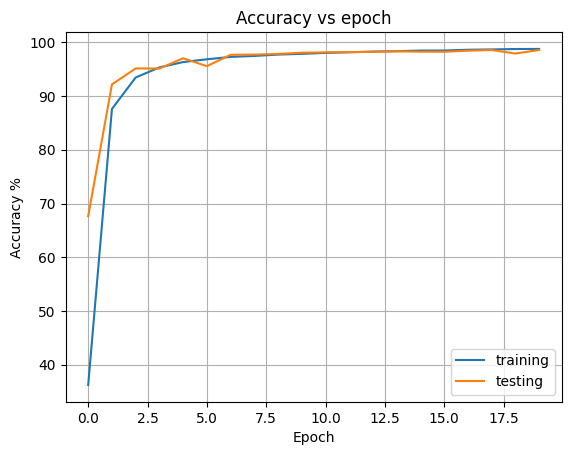

In [14]:
plt.plot([i[0] for i in train_plot], label='training')
plt.plot([i[0] for i in test_plot], label='testing')
plt.grid()
plt.legend()
plt.title('Accuracy vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')

Text(0, 0.5, 'Loss')

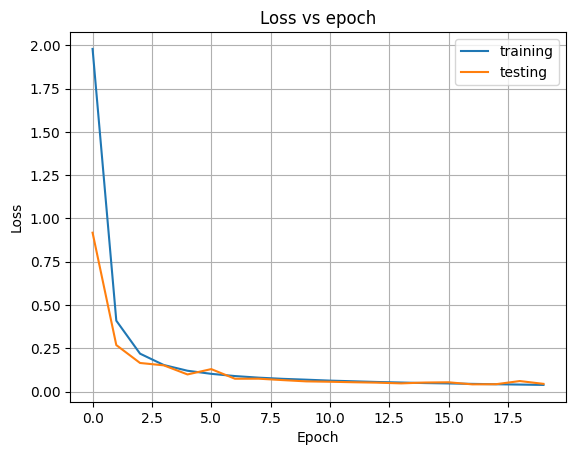

In [15]:
plt.plot([i[1] for i in train_plot], label='training')
plt.plot([i[1] for i in test_plot], label='testing')
plt.grid()
plt.legend()
plt.title('Loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [16]:
model.output_first_conv2d.shape

torch.Size([16, 6, 28, 28])